In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import os
import json
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'

import haiku as hk
import functools
from deeprte.config import get_config
from deeprte.model.modules import DeepRTE
from deeprte.model.tf.input_pipeline import load_tf_data
from deeprte.model.data import flat_params_to_haiku

from deeprte.model.tf.rte_features import BATCH_FEATURE_NAMES

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test_example -> scattering kernel -> matlab generates coefficient and bc conditions -> use deeprte to solve each bc condition -> sum

test_example -> generates coefficient and bc conditions -> use deeprte to solve each bc condition -> sum

In [2]:
var_x = 0.020
var_v = 0.010
n = 40
nv = 12

mesh_x = np.linspace(0,1,n+1)
mesh_ct = np.squeeze(np.array([[ 0.25544139],
       [ 0.69309572],
       [ 0.28708965],
       [ 0.93802334],
       [ 0.68668074],
       [ 0.2513426 ],
       [-0.25544139],
       [-0.28708965],
       [-0.69309572],
       [-0.2513426 ],
       [-0.68668074],
       [-0.93802334],
       [-0.25544139],
       [-0.69309572],
       [-0.28708965],
       [-0.93802334],
       [-0.68668074],
       [-0.2513426 ],
       [ 0.25544139],
       [ 0.28708965],
       [ 0.69309572],
       [ 0.2513426 ],
       [ 0.68668074],
       [ 0.93802334]]))
mesh_st = np.squeeze(np.array([[ 0.25544139],
       [ 0.28708965],
       [ 0.69309572],
       [ 0.2513426 ],
       [ 0.68668074],
       [ 0.93802334],
       [ 0.25544139],
       [ 0.69309572],
       [ 0.28708965],
       [ 0.93802334],
       [ 0.68668074],
       [ 0.2513426 ],
       [-0.25544139],
       [-0.28708965],
       [-0.69309572],
       [-0.2513426 ],
       [-0.68668074],
       [-0.93802334],
       [-0.25544139],
       [-0.69309572],
       [-0.28708965],
       [-0.93802334],
       [-0.68668074],
       [-0.2513426 ]]))

In [3]:
def bc_func_x(x, x_c):
    def f(x):
        return np.exp(-(x-x_c)**2/2/var_x)
    sum = np.sum(f(mesh_x))
    return np.exp(-(x-x_c)**2/2/var_x)/sum


def bc_func_v(ct,st, ct_c, st_c):
    def f(_ct,_st):
        return np.exp(-(_ct-ct_c)**2/2/var_v)*np.exp(-(_st-st_c)**2/2/var_v)
    sum = np.sqrt(np.sum(f(mesh_ct, mesh_st)))
    return f(ct,st)/sum


In [4]:
idx = (mesh_ct>0)*(mesh_st>0)+(mesh_ct>0)*(mesh_st<0)
mesh_ct_L = [ct for ct in idx*mesh_ct if ct != 0]
mesh_st_L = [st for st in idx*mesh_st if st != 0]
idx_list = [i for i in range(2*nv) if idx[i] != 0]

In [5]:
psi_bc = []

for x_c in mesh_x:
    for i, ct_c in enumerate(mesh_ct_L):
        st_c = mesh_st_L[i]
        bc = bc_func_x(mesh_x, x_c)[...,None]*bc_func_v(mesh_ct_L, mesh_st_L, ct_c, st_c)
        psi_bc.append(bc)

psi_bc = np.stack(psi_bc, axis=0)

In [6]:
num = psi_bc.shape[0]
psi_bc = psi_bc.reshape(num,-1)

In [7]:
from scipy import linalg

coef = linalg.inv(psi_bc)

In [8]:
coef

array([[-4.09175307e+11, -8.18153135e+09,  1.27477010e+09, ...,
        -3.27862725e+02, -3.64722795e+01, -4.37243089e+03],
       [ 2.77188168e+08,  1.90986357e+11, -4.41889090e+05, ...,
         3.40267333e-01,  2.70465087e+02,  2.06520578e+05],
       [-9.09849590e+07, -1.53080325e+06,  8.31839281e+10, ...,
        -5.23209392e-02, -6.28297497e-03, -1.01656715e+00],
       ...,
       [ 1.70205660e+02, -3.85960402e+00,  1.98856826e-01, ...,
         2.87301859e+10, -4.22828216e+07,  2.84477209e+04],
       [-1.72390546e+00, -3.06287753e+02,  1.79463711e-03, ...,
         2.66271844e+07,  5.57692033e+10, -1.40735846e+07],
       [-2.47875251e+02, -1.23854561e+06,  1.17135639e+00, ...,
        -4.30909478e+03,  1.61090473e+06,  5.01133444e+09]])

In [9]:
from scipy import linalg
coef = linalg.solve(psi_bc, np.ones((num,)))

/tmp/ipykernel_3057897/3017254065.py:2: LinAlgWarning: Ill-conditioned matrix (rcond=4.92974e-20): result may not be accurate.
  coef = linalg.solve(psi_bc, np.ones((num,)))


In [10]:
np.allclose(psi_bc.dot(coef), np.ones((num,)))

True

In [11]:
psi_bc[0][psi_bc[0]>1e-6]

array([1.31746543e-01, 8.68405840e-06, 8.68405840e-06, 1.29704002e-01,
       8.54942455e-06, 8.54942455e-06, 1.23764423e-01, 8.15791790e-06,
       8.15791790e-06, 1.14463380e-01, 7.54484069e-06, 7.54484069e-06,
       1.02604310e-01, 6.76315148e-06, 6.76315148e-06, 8.91441698e-02,
       5.87592783e-06, 5.87592783e-06, 7.50669171e-02, 4.94802732e-06,
       4.94802732e-06, 6.12678322e-02, 4.03846220e-06, 4.03846220e-06,
       4.84668444e-02, 3.19468655e-06, 3.19468655e-06, 3.71608187e-02,
       2.44945114e-06, 2.44945114e-06, 2.76155755e-02, 1.82027753e-06,
       1.82027753e-06, 1.98907529e-02, 1.31109672e-06, 1.31109672e-06,
       1.38859834e-02, 9.39572637e-03, 6.16186779e-03, 3.91672147e-03,
       2.41302210e-03, 1.44088131e-03, 8.33918123e-04, 4.67785671e-04,
       2.54330658e-04, 1.34022839e-04, 6.84521680e-05, 3.38862804e-05,
       1.62588150e-05, 7.56105116e-06, 3.40803277e-06, 1.48885925e-06])

In [12]:
psi_bc@coef

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [13]:
coef

array([ 7.89748663e-01,  1.03709135e+00,  9.82312115e-01,  9.63574518e-01,
        1.04863582e+00,  1.02090800e+00,  1.03049204e+00,  1.10277033e+00,
        9.01767496e-01,  9.92099533e-01,  1.01537973e+00,  1.01180950e+00,
        3.07953542e+00,  3.50996838e-01,  9.06407622e-01,  1.11983011e+00,
        5.01473938e-01,  5.34870309e-01,  6.63077385e-01, -4.55489432e-01,
        1.75769655e+00,  7.64862863e-01,  8.48242465e-01,  6.69933716e-01,
       -8.30430977e+00,  3.99974269e+00,  1.43717601e+00,  3.27348143e-01,
        3.32284445e+00,  3.05923033e+00,  2.76155100e+00,  8.67058419e+00,
       -2.72019905e+00,  2.33466329e+00,  1.64478022e+00,  2.13983662e+00,
        2.51025347e+01, -7.77131357e+00, -8.74236240e-01,  2.61922908e+00,
       -5.42294651e+00, -4.94838641e+00, -4.80330261e+00, -2.45922485e+01,
        1.13644065e+01, -4.12248630e+00, -4.95094235e-01, -1.12573581e+00,
       -3.64152413e+01,  1.72933441e+01,  6.10755495e+00, -1.12675148e+00,
        1.22015604e+01,  

In [14]:
def slice_batch(i: int, feat: dict):
    return {
        k: feat[k][i:i+1] if k in BATCH_FEATURE_NAMES else feat[k] for k in feat
    }

rng = hk.PRNGSequence(jax.random.PRNGKey(42))

In [15]:
config = get_config()
config = config.experiment_kwargs.config
# config.model.green_function.scattering.res_block_depth = 2

In [16]:
config.model.green_function

attenuation:
  attention:
    key_chunk_size: 128
    key_dim: 32
    num_head: 2
    output_dim: 2
    value_dim: null
  latent_dim: 128
  num_layer: 4
  output_dim: 16
scattering:
  latent_dim: 16
  num_layer: 2

In [17]:
# config.model.green_function.attenuation.output_dim = 32
# config.model.green_function.scattering.latent_dim = 32

In [18]:
source_dir = "/workspaces/deeprte/rte_data/matlab/eval-data/scattering-kernel"
data_name_list = ["test_bc1_fixedvar_scattering_kernel.mat"]

# source_dir = "/workspaces/deeprte/rte_data/matlab/train-scattering-kernel"
# data_name_list = ["test_random_kernel_scale5.mat"]

PARAMS_FILE = "/workspaces/deeprte/ckpts/train_scattering_kernel_2023-02-16T14:04:06/models/latest/step_1200000_2023-02-19T22:37:17/params.npz"
CONFIG_PATH = "/workspaces/deeprte/ckpts/train_scattering_kernel_2023-02-16T14:04:06/config.json"

In [19]:
tf_data = load_tf_data(source_dir, data_name_list, normalization=False)
features = jax.tree_map(lambda x: np.array(x), tf_data)
jax.tree_util.tree_map(lambda x: x.shape, features)

({'boundary': (10, 1968),
  'boundary_coords': (1968, 4),
  'boundary_weights': (1968,),
  'phase_coords': (40344, 4),
  'position_coords': (1681, 2),
  'psi_label': (10, 40344),
  'scattering_kernel': (10, 40344, 24),
  'self_scattering_kernel': (10, 24, 24),
  'sigma': (10, 1681, 2),
  'velocity_coords': (24, 2),
  'velocity_weights': (24,)},
 {})

In [20]:
data_feature = features[0]

In [21]:
idx = 0
batch = slice_batch(idx, data_feature)
jax.tree_util.tree_map(lambda x: x.shape, batch)

{'boundary': (1, 1968),
 'boundary_coords': (1968, 4),
 'boundary_weights': (1968,),
 'phase_coords': (40344, 4),
 'position_coords': (1681, 2),
 'psi_label': (1, 40344),
 'scattering_kernel': (1, 40344, 24),
 'self_scattering_kernel': (1, 24, 24),
 'sigma': (1, 1681, 2),
 'velocity_coords': (24, 2),
 'velocity_weights': (24,)}

In [22]:
num = psi_bc.shape[0]
psiL = batch["boundary"][0][:num]
psi_bc = psi_bc.reshape(num,-1)

coef = linalg.solve(psi_bc, psiL)

/tmp/ipykernel_3057897/4259819679.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.92974e-20): result may not be accurate.
  coef = linalg.solve(psi_bc, psiL)


In [23]:
psi_bc = np.concatenate([psi_bc,np.zeros((num, batch["boundary"].shape[1]-num))],axis=1)

In [24]:
psi_bc.shape

(492, 1968)

In [25]:
with open(CONFIG_PATH,'r',encoding='utf8') as fp:
    json_data = json.load(fp)

In [26]:
normalization_dict = json_data["experiment_kwargs"]["config"]["model"]["data"]["normalization_dict"]

In [27]:
np_params = np.load(PARAMS_FILE)
params = flat_params_to_haiku(np_params)
jax.tree_util.tree_map(lambda x: x.shape, params)

{'deeprte/green_function/attenuation/attention_v2/key': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attention_v2/output_projection': {'b': (2,),
  'w': (64, 2)},
 'deeprte/green_function/attenuation/attention_v2/query': {'b': (64,),
  'w': (4, 64)},
 'deeprte/green_function/attenuation/attention_v2/value': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attenuation_linear': {'b': (128,),
  'w': (10, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_1': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_2': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/output_projection': {'b': (16,),
  'w': (128, 16)},
 'deeprte/green_function/output_projection': {'w': (16, 1)},
 'deeprte/green_function/scattering_module/__layer_stack_no_per_layer/scattering_layer/linear': {'b': (2,
   16),
  'w': (2, 16, 16)}}

In [28]:
dev_num = 2
params_dev = jax.tree_map(lambda x: np.stack([x for i in range(dev_num)]), params)

In [29]:
jax.tree_util.tree_map(lambda x: x.shape, params_dev)

{'deeprte/green_function/attenuation/attention_v2/key': {'b': (2, 64),
  'w': (2, 2, 64)},
 'deeprte/green_function/attenuation/attention_v2/output_projection': {'b': (2,
   2),
  'w': (2, 64, 2)},
 'deeprte/green_function/attenuation/attention_v2/query': {'b': (2, 64),
  'w': (2, 4, 64)},
 'deeprte/green_function/attenuation/attention_v2/value': {'b': (2, 64),
  'w': (2, 2, 64)},
 'deeprte/green_function/attenuation/attenuation_linear': {'b': (2, 128),
  'w': (2, 10, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_1': {'b': (2, 128),
  'w': (2, 128, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_2': {'b': (2, 128),
  'w': (2, 128, 128)},
 'deeprte/green_function/attenuation/output_projection': {'b': (2, 16),
  'w': (2, 128, 16)},
 'deeprte/green_function/output_projection': {'w': (2, 16, 1)},
 'deeprte/green_function/scattering_module/__layer_stack_no_per_layer/scattering_layer/linear': {'b': (2,
   2,
   16),
  'w': (2, 2, 16, 16)}}

In [30]:
def forward_fn(batch, is_training):
    out = DeepRTE(config.model)(batch, is_training=is_training, compute_loss=True, compute_metrics=False)
    return out

forward = hk.transform(forward_fn)
apply = jax.pmap(functools.partial(forward.apply, is_training = False))
# init = jax.jit(functools.partial(forward.init, is_training = True))

In [31]:
phi_label = jnp.dot(batch["psi_label"].reshape(41,41,24),batch["velocity_weights"])

In [32]:
jax.tree_map(lambda x: x.shape, batch)

{'boundary': (1, 1968),
 'boundary_coords': (1968, 4),
 'boundary_weights': (1968,),
 'phase_coords': (40344, 4),
 'position_coords': (1681, 2),
 'psi_label': (1, 40344),
 'scattering_kernel': (1, 40344, 24),
 'self_scattering_kernel': (1, 24, 24),
 'sigma': (1, 1681, 2),
 'velocity_coords': (24, 2),
 'velocity_weights': (24,)}

In [33]:
psi_bc.shape

(492, 1968)

In [34]:
batch_num = coef.shape[0]
eval_batch = {
        k: np.repeat(batch[k],batch_num, axis=0)  if k in BATCH_FEATURE_NAMES else batch[k] for k in batch
    }
eval_batch["boundary"] = psi_bc

In [35]:
jax.tree_map(lambda x: x.dtype, eval_batch)

{'boundary': dtype('float64'),
 'boundary_coords': dtype('float32'),
 'boundary_weights': dtype('float32'),
 'phase_coords': dtype('float32'),
 'position_coords': dtype('float32'),
 'psi_label': dtype('float32'),
 'scattering_kernel': dtype('float32'),
 'self_scattering_kernel': dtype('float32'),
 'sigma': dtype('float32'),
 'velocity_coords': dtype('float32'),
 'velocity_weights': dtype('float32')}

In [36]:
def split_subbatch(feat):
    # print(*(feat["boundary"].shape[1:]))
    if feat.shape[0] == num:
        return feat.reshape(-1, dev_num, 1, *feat.shape[1:])
    else:
        return feat

In [37]:
dev_num

2

In [38]:
_eval_batch = jax.tree_util.tree_map(split_subbatch, eval_batch)

In [39]:
jax.tree_util.tree_map(lambda x: x.shape, _eval_batch)

{'boundary': (246, 2, 1, 1968),
 'boundary_coords': (1968, 4),
 'boundary_weights': (1968,),
 'phase_coords': (40344, 4),
 'position_coords': (1681, 2),
 'psi_label': (246, 2, 1, 40344),
 'scattering_kernel': (246, 2, 1, 40344, 24),
 'self_scattering_kernel': (246, 2, 1, 24, 24),
 'sigma': (246, 2, 1, 1681, 2),
 'velocity_coords': (24, 2),
 'velocity_weights': (24,)}

In [40]:
from jaxline import utils as jl_utils
import tensorflow as tf

In [41]:
# _batch = jax.tree_util.tree_map(lambda x: x[0] if x.shape[0] == num/dev_num else np.stack([x for i in range(dev_num)]), _eval_batch)

In [42]:
# r = next(rng)

In [43]:
# _, ret = apply(params_dev, jl_utils.bcast_local_devices(next(rng)), _batch)

In [44]:
psi = []
for i in range(int(num/dev_num)):
    _batch = jax.tree_util.tree_map(lambda x: x[i] if x.shape[0] == num/dev_num else np.stack([x for _ in range(dev_num)]), _eval_batch)
    _, ret = apply(params_dev, jl_utils.bcast_local_devices(next(rng)), _batch)
    psi.append(ret["predicted_solution"])
psi = np.stack(psi)

In [45]:
# psi = 0
# for i, a in enumerate(coef):
#     batch["boundary"] = batch["boundary"].at[0].set(psi_bc[i])
#     _, ret = apply(params, next(rng), batch)
#     psi += ret["predicted_solution"].reshape(41,41,24)*coef[i]

In [46]:
predicted_solution = psi.reshape(-1,41,41,24)

In [47]:
predicted_solution.shape

(492, 41, 41, 24)

In [48]:
# predicted_solution = ret["predicted_solution"].reshape(-1,41,41,24)
psi = jnp.einsum("ijkl,i->jkl", predicted_solution, coef)

In [49]:
psi.shape

(41, 41, 24)

In [50]:
phi_pre = jnp.dot(psi.reshape(41,41,24),batch["velocity_weights"])
print(jnp.sqrt(jnp.mean((phi_label - phi_pre)**2)/jnp.mean(phi_label**2)), idx)

0.79748124 0


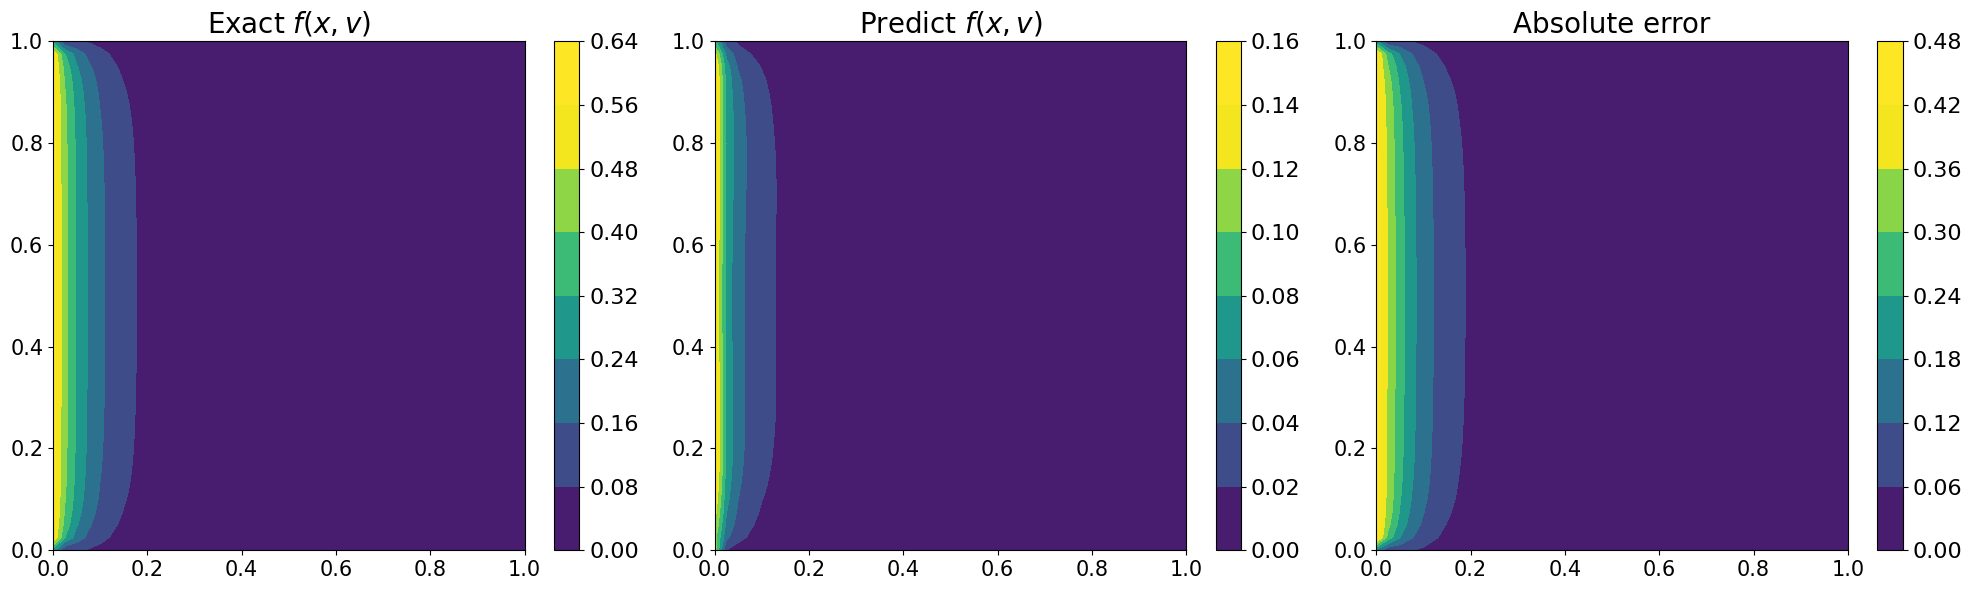

0.7974813


In [51]:
import matplotlib.pyplot as plt
# import plotly.express as px
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = mpl.colormaps['viridis'](np.linspace(0, 1.2, 128))
r = batch['position_coords'].reshape(41,41,2)


fig, _axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6) )
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

# fig = px.density_contour(phi_label)
# fig.show()

cs_1 = axs[0].contourf(
    r[..., 0],
    r[..., 1],
    phi_label,
    cmap = ListedColormap(viridis)
)
axs[0].set_title(r"Exact $f(x,v)$", fontsize=20)
axs[0].tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(cs_1)
cbar.ax.tick_params(labelsize=16) 


# fig = px.density_contour(phi_pre)
cs_2 = axs[1].contourf(
    r[..., 0],
    r[..., 1],
    phi_pre,
        cmap = ListedColormap(viridis)
)
axs[1].set_title(r"Predict $f(x,v)$", fontsize=20)
axs[1].tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(cs_2)
cbar.ax.tick_params(labelsize=16) 

cs_3 = axs[2].contourf(
    r[..., 0],
    r[..., 1],
    abs(phi_pre-phi_label),
    cmap = ListedColormap(viridis)
)
axs[2].set_title(r"Absolute error", fontsize=20)
axs[2].tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(cs_3)
cbar.ax.tick_params(labelsize=16) 

plt.tight_layout()

plt.show()
print(np.sqrt(np.mean((phi_label - phi_pre)**2)/np.mean(phi_label**2)))